In [3]:
from helper import *
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random

imgDir = '../../data/EnglishFnt/'

def shuffleData(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices,:,:,:]
    y = y[indices]
    sep = int(0.8 * len(X))
    x_train = X[:sep,:,:,:]
    y_train = y[:sep]
    x_test = X[sep:,:,:]
    y_test = y[sep:]
    return (x_train, y_train), (x_test, y_test)

def gray2binary(gray, threshold):
    bw = gray
    idx1 = gray <= threshold
    idx2 = gray >= threshold
    bw[idx1] = 255
    bw[idx2] = 0
    return bw

def one_hot_encode(x, size):
    y = np.zeros((len(x), size))
    for i in range(len(x)):
        k = x[i]
        y[i][k] = 1
    return y

def batchData(features, labels, batch_size):
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

In [4]:
# original size
# nh = 128, nw = 128
nh = 24 
nw = 24

data = []
label = []

for s in os.listdir(imgDir):
    if s[6:].isdigit():
        y = int(s[6:])
    else:
        continue
    if (y == 4 or y > 5):
        continue
    subdir = os.path.join(imgDir, s)
    samples = load_image_png(subdir, nh, nw)
    t = np.ones(len(samples), dtype=np.uint8) * (y - 1)
    data.append(samples)
    label.append(t)
    print(samples.shape)
    
data = np.array(data)
data = np.reshape(data, (1016 * 4, nh, nw, 1))

label = np.array(label)
label = np.reshape(label, 1016 * 4)

data = gray2binary(data, 127)
data = data / 255.0

/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(1016, 24, 24)
(1016, 24, 24)
(1016, 24, 24)
(1016, 24, 24)


In [5]:
# 数据集扩充
# 平移
nh = 24
nw = 24
shift = 4

n = len(data)

for i in range(-2, 3):
    kx = i * shift
    if kx >= 0:
        ix1, ix2 = 0, nh - kx
    else:
        ix1, ix2 = -kx, nh
    jx1, jx2 = ix1 + kx, ix2 + kx
        
    for j in range(-2, 3):
        if i == 0 and j == 0:
            continue
        #if abs(i) == 2 and abs(j) == 2:
        #    continue
        
        ky = j * shift
        if ky >= 0:
            iy1, iy2 = 0, nw - ky
        else:
            iy1, iy2 = -ky, nw
        jy1, jy2 = iy1 + ky, iy2 + ky
        
        augdata = np.zeros((n, nh, nw, 1))
        augdata[:, ix1:ix2, iy1:iy2, :] = data[:n, jx1:jx2, jy1:jy2, :]
        
        augy = label[:n]
    
        data = np.concatenate((data, augdata), axis=0)
        label = np.hstack((label, augy))   

In [6]:
samples = data
(x_train, y_train),(x_test, y_test) = shuffleData(samples, label)

In [7]:
label_train = y_train.copy()
y_train[label_train == 4] = 3

label_test = y_test.copy()
y_test[label_test == 4] = 3

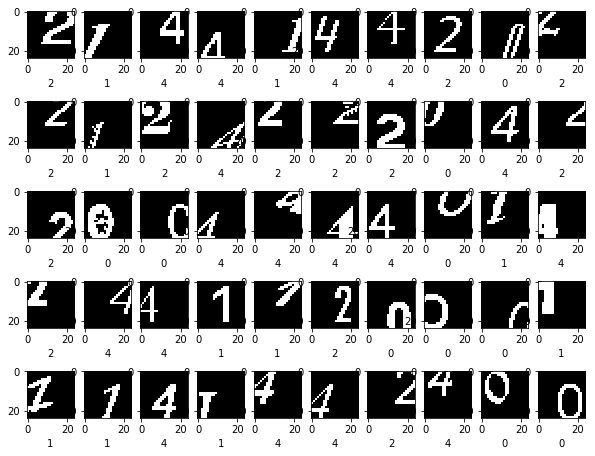

In [8]:
fm = 5
fn = 10

plt.figure(figsize=(10, 8))

for i in range(fm):
    for j in range(fn):

        k = random.randint(0, len(y_test))
        pic = np.reshape(x_test[k, :, :, :], (nh, nh))

        plt.subplot(fm, fn, i * fn + j + 1)
        plt.imshow(pic, cmap='gray')
        plt.xlabel(label_test[k])
    
plt.show()

In [29]:
import tensorflow as tf

# Parameters
learning_rate = 0.0001
keep_prob = 0.2
num_steps = 60
batch_size = 128
display_step = 100

# Network Parameters
n_hidden_1 = 16 # 1st layer number of neurons
n_hidden_2 = 32 # 2nd layer number of neurons
num_input = 24 * 24 # MNIST data input (img shape: 28*28)
num_classes = 4 # MNIST total classes (0-9 digits)


# Define the neural network
def neural_net(input_tensor, keep_prob):
    x = tf.layers.flatten(input_tensor)

    layer_1 = tf.layers.dense(x, n_hidden_1, activation=tf.nn.relu)
    layer_1 = tf.layers.dropout(layer_1, keep_prob)
 
    layer_2 = tf.layers.dense(layer_1, n_hidden_2, activation=tf.nn.relu)
    layer_2 = tf.layers.dropout(layer_2, keep_prob)

    out_layer = tf.layers.dense(layer_2, num_classes)
    out_layer = tf.nn.softmax(out_layer)
    return out_layer



def cnn_net(input_tensor, keep_prob) :
    #x = tf.layers.Input(shape=[-1, 24, 24, 1])
    #x = tf.layers.Input(tensor=input_tensor)
    x = tf.reshape(input_tensor, (-1, 24, 24, 1))
    y = tf.layers.conv2d(x, filters=16, kernel_size=3, activation=tf.nn.relu)
    y = tf.layers.conv2d(y, filters=32, kernel_size=3, activation=tf.nn.relu)
    y = tf.layers.dense(y, num_classes)
    out_layer = tf.nn.softmax(y)
    return out_layer



x_train = np.reshape(x_train, (len(x_train), 24, 24))
x_test = np.reshape(x_test, (len(x_test), 24, 24))
y_train_ = one_hot_encode(y_train, num_classes)
y_test_ = one_hot_encode(y_test, num_classes)



x = tf.placeholder(tf.float32, shape=[None, 24, 24], name='x')
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
#y = tf.placeholder(tf.float32, shape=(None))

p = tf.placeholder(tf.float32, name='p')


logit = neural_net(x, p)
#logit = cnn_net(x, p)

logit = tf.identity(logit, name='logit')
cross_entropy = -tf.reduce_sum(y * tf.log(logit))


train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(logit, 1), tf.argmax(y, 1))
#correct_prediction = tf.equal(tf.argmax(logit, 1), y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"), name='accuracy')


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    k = 0
    for i in range(num_steps):

        for x_batch, y_batch in batchData(x_train, y_train_, batch_size):
            
            k += 1
            sess.run(train_step, feed_dict={x: x_batch, y: y_batch, p: keep_prob})
         
            #train_accuracy = accuracy.eval(feed_dict={x: x_batch, y: y_batch, p: keep_prob})    
            #print "step %d, training accuracy %g"%(i, train_accuracy)

        if i%5 == 0:
            print("{}/{} test accuracy {}".format(i, num_steps, accuracy.eval(feed_dict={x: x_test, y: y_test_, p: 1.0})))
        
    save_path = './model/test'
    saver = tf.train.Saver()
    saver.save(sess, save_path)
    
    save_pb_path = './model_pb'
    builder = tf.saved_model.builder.SavedModelBuilder(save_pb_path)
    builder.add_meta_graph_and_variables(sess, ["mytag"])
    builder.save()

0/60 test accuracy 0.5970472693443298
5/60 test accuracy 0.8692421317100525
10/60 test accuracy 0.8988189101219177
15/60 test accuracy 0.9104330539703369
20/60 test accuracy 0.9183562994003296
25/60 test accuracy 0.9244094491004944
30/60 test accuracy 0.9283464550971985
35/60 test accuracy 0.9316437244415283
40/60 test accuracy 0.9339566826820374
45/60 test accuracy 0.936515748500824
50/60 test accuracy 0.9381889700889587
55/60 test accuracy 0.9399606585502625
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'./model_pb/saved_model.pb'


In [42]:
gc = 127
nh = 24
nw = 32

samples, label = load_image_x("./test", nh, nw)

n = len(label)

x_real = preprocess(samples, 4, 100)
x_real = np.reshape(x_real, (n, nh, nh, 1))
y_real = label
y_real[label == 4] = 3

/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(1, 24, 32, 3)
(16, 24, 32, 3)
(1, 24, 32, 3)
(5, 24, 32, 3)


In [35]:
x_real_ = np.reshape(x_real, (len(x_real), 24, 24))
y_real_ = one_hot_encode(y_real, num_classes)

print(save_model)
save_model = save_path
saver = tf.train.Saver()

with tf.Session() as sess:

    saver.restore(sess, save_model)
    y_pred = sess.run(logit, feed_dict={x: x_real_, p: 1.0})
    test_accuracy = sess.run(accuracy, feed_dict={x: x_real_, y: y_real_, p: 1.0})
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print(y_pred)

./model/test
INFO:tensorflow:Restoring parameters from ./model/test
Test Accuracy = 0.652
[[9.9941611e-01 3.3387223e-05 3.0539005e-09 5.5057177e-04]
 [4.7293442e-01 4.8846905e-06 4.4075117e-01 8.6309545e-02]
 [9.7088957e-01 6.4332020e-03 2.1765100e-02 9.1213628e-04]
 [1.1726889e-03 9.9843913e-01 2.1087223e-04 1.7717994e-04]
 [3.9315615e-02 8.0427432e-01 1.5640053e-01 9.5262085e-06]
 [9.9995649e-01 3.3802415e-08 4.3537584e-05 1.2503674e-21]
 [2.5999177e-06 9.9994314e-01 5.4184897e-05 8.8873636e-10]
 [3.8053902e-06 9.9996912e-01 2.7043165e-05 7.4068836e-09]
 [9.2771100e-03 3.4374557e-06 9.8215497e-01 8.5645923e-03]
 [8.5750152e-13 9.9999845e-01 5.1088959e-12 1.4996027e-06]
 [4.1153483e-04 9.9909317e-01 4.4128447e-04 5.4015993e-05]
 [8.6919141e-01 4.5151923e-02 8.5656740e-02 1.4318489e-12]
 [2.6068118e-01 7.3568785e-01 1.9488190e-03 1.6820648e-03]
 [9.2168511e-06 9.9995565e-01 2.0864476e-05 1.4340643e-05]
 [3.4332156e-04 9.9963272e-01 1.8564708e-05 5.3697786e-06]
 [1.5583927e-02 1.2185275

In [34]:
x_real_ = np.reshape(x_real, (len(x_real), 24, 24))
y_real_ = one_hot_encode(y_real, num_classes)

save_model = save_path

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    loader = tf.train.import_meta_graph(save_model + '.meta')
    loader.restore(sess, save_model)
    loaded_x = loaded_graph.get_tensor_by_name('x:0')
    loaded_y = loaded_graph.get_tensor_by_name('y:0')
    loaded_p = loaded_graph.get_tensor_by_name('p:0')
    loaded_logit = loaded_graph.get_tensor_by_name('logit:0')
    loaded_accuracy = loaded_graph.get_tensor_by_name('accuracy:0')
    
    y_pred = sess.run(loaded_logit, feed_dict={loaded_x: x_real_, loaded_p: 1.0})
    test_accuracy = sess.run(loaded_accuracy, feed_dict={loaded_x: x_real_, loaded_y: y_real_, loaded_p: 1.0})
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print(y_pred)

INFO:tensorflow:Restoring parameters from ./model/test


InvalidArgumentError: You must feed a value for placeholder tensor 'x_2' with dtype float and shape [?,24,24]
	 [[Node: x_2 = Placeholder[dtype=DT_FLOAT, shape=[?,24,24], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'x_2', defined at:
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-af2bb13dbfb0>", line 8, in <module>
    loader = tf.train.import_meta_graph(save_model + '.meta')
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1955, in import_meta_graph
    **kwargs)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/meta_graph.py", line 743, in import_scoped_meta_graph
    producer_op_list=producer_op_list)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 432, in new_func
    return func(*args, **kwargs)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/importer.py", line 513, in import_graph_def
    _ProcessNewOps(graph)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/importer.py", line 303, in _ProcessNewOps
    for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3540, in _add_new_tf_operations
    for c_op in c_api_util.new_tf_operations(self)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3540, in <listcomp>
    for c_op in c_api_util.new_tf_operations(self)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3428, in _create_op_from_tf_operation
    ret = Operation(c_op, self)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'x_2' with dtype float and shape [?,24,24]
	 [[Node: x_2 = Placeholder[dtype=DT_FLOAT, shape=[?,24,24], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


[0 0 0 1 1 0 1 1 2 1 1 0 1 1 1 2 1 2 4 0 0 4 4]


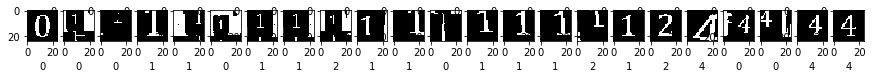

In [36]:
y_pred_i = y_pred.argmax(1)
y_label = y_pred_i
y_label[y_pred_i == 3] = 4
print(y_pred_i)

plt.figure(figsize=(15, 3))

for i in range(n):
    plt.subplot(1, n, i + 1)

    pic = np.reshape(x_real[i,:,:,:], (nh, nh))
    
    plt.imshow(pic, cmap='gray')
    plt.xlabel(str(y_label[i]))
    
plt.show()

## model restore ##

In [41]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
 
    
# pb模型的恢复
def restore_model_pb():
    sess = tf.Session()
    tf.saved_model.loader.load(sess, ['mytag'], save_pb_path)
    input_x = sess.graph.get_tensor_by_name('x:0')
    input_p = sess.graph.get_tensor_by_name('p:0')
    op = sess.graph.get_tensor_by_name('logit:0')
    #op = sess.graph.get_tensor_by_name('accuracy:0')
    #print(sess.run(type(input_x)))
    output = sess.run(op, feed_dict={input_x: x_real_, input_p: 1.0})
    #output = sess.run(op, feed_dict={x: x_real_, y: y_real_, p: 1.0})
    print(output)
    sess.close()

print(type(x_real_))
print(x_real_.shape)
restore_model_pb()

<class 'numpy.ndarray'>
(23, 24, 24)
INFO:tensorflow:Restoring parameters from b'./model_pb/variables/variables'


InvalidArgumentError: You must feed a value for placeholder tensor 'x_2' with dtype float and shape [?,24,24]
	 [[Node: x_2 = Placeholder[dtype=DT_FLOAT, shape=[?,24,24], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'x_2', defined at:
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-63185676e26d>", line 52, in <module>
    x = tf.placeholder(tf.float32, shape=[None, 24, 24], name='x')
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1808, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4848, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'x_2' with dtype float and shape [?,24,24]
	 [[Node: x_2 = Placeholder[dtype=DT_FLOAT, shape=[?,24,24], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
# ckpt模型的恢复
def restore_model_ckpt():
    sess = tf.Session()
    # 加载模型结构
    saver = tf.train.import_meta_graph('./save_path/file_name.meta')
    # 只需要指定目录就可以恢复所有变量信息
    saver.restore(sess, tf.train.latest_checkpoint('./save_path'))
    # 直接获取保存的变量
    print(sess.run('w:0'))
 
    input_x = sess.graph.get_tensor_by_name('input_x:0')
    # # 获取需要进行计算的operator
    op = sess.graph.get_tensor_by_name('predict:0')
    print(sess.run(op, feed_dict={input_x: np.expand_dims(mnist.test.images[15], axis=0)}))
    sess.close()

